In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Figure 3.1  --- #

# Computes part of the unoscillated reactor neutrinos flux at energy Enu (arXiv:1101.2663, arXiv:1411.6475).
def flux(Enu):
    
    # Isotope fractions and mean energies
    tf_iso = [0.58, 0.07, 0.3, 0.05] # U235, U238, Pu239, and Pu241
    ef_iso = [202.36, 205.99, 211.12, 214.26]
    
    # Parametrization coefficients
    a0 = [3.217, 4.833e-1, 6.413, 3.251]
    a1 = [-3.111, 1.927e-1, -7.432, -3.204]
    a2 = [1.395, -1.283e-1, 3.535, -1.428]
    a3 = [-3.69e-1, -6.762e-3, -8.82e-1, -3.675e-1]
    a4 = [4.445e-2, 2.233e-3, 1.025e-1, 4.254e-2]
    a5 = [-2.053e-3, -1.536e-4, -4.55e-3, -1.896e-3]
    
    # Calculating
    fator = 0.0
    fluxo = 0.0
    for i in range(4):
        fator += tf_iso[i]*ef_iso[i]
        fluxo += tf_iso[i] * np.exp(a0[i] + a1[i]*Enu + a2[i]*Enu**2.0 + a3[i]*Enu**3.0 + a4[i]*Enu**4.0 + a5[i]*Enu**5.0)
    
    fluxo = fluxo/fator
    return fluxo

In [3]:
# Computes the 3-flavor electron antineutrino survival probability P_surv
def Psurv_withme(Enu, L, t12, t13, t23, dm21, dm31, Ye, rho):
    
    # Mass-squared difference Δm²₃₂
    dm32 = dm31 - dm21
    
    # Converting mixing angles to radians
    t12 = np.deg2rad(t12)
    t13 = np.deg2rad(t13)
    t23 = np.deg2rad(t23)
    
    # Sines and cosines of the mixing angles
    s2_t12 = np.sin(t12)**2
    c2_t12 = np.cos(t12)**2
    c_2t12 = np.cos(2.0*t12)
    s2_2t12 = np.sin(2.0*t12)**2
    s2_2t13 = np.sin(2.0*t13)**2
    c4_t13 = np.cos(t13)**4
    
    # Oscillation phases in vacuum
    d21 = 1.27e3*dm21*L/Enu
    d31 = 1.27e3*dm31*L/Enu
    d32 = 1.27e3*dm32*L/Enu
    s2_d21 = np.sin(d21)**2
    s2_d31 = np.sin(d31)**2
    s2_d32 = np.sin(d32)**2
    
    # Matter potential (constant density approximation)
    Acc = 1.52e-7*Ye*rho*Enu
    
    # Mixing angle θ₁₂ and Δm²₂₁ in matter (approximate)
    s2_t12m = s2_t12*(1.0 + 2.0*Acc*np.cos(t12)/dm21)
    c2_t12m = 1 - s2_t12m
    s2_2t12m = s2_2t12*(1.0 + 2.0*Acc*c_2t12/dm21)
    dm21m = dm21*(1 - Acc*c_2t12/dm21)
    d21m = 1.27e3*dm21m*L/Enu
    s2_d21m = np.sin(d21m)**2
    
    # Final expression for the probability with matter effects
    prob = 1.0 - s2_2t12m*c4_t13*s2_d21m - s2_2t13*(c2_t12m*s2_d31 + s2_t12m*s2_d32)
    return prob

In [4]:
# Computes the JUNO-averaged electron antineutrino survival probability for both Normal and Inverted Orderings
def Psurv_JUNO(Enu):
    
    # Reactor baselines to JUNO's main detector in km
    L = [52.77, 52.77, 52.74, 52.82, 52.41, 52.49, 52.11, 52.19]
    
    # Reactor thermal powers in GWth
    W = [4.6, 4.6, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9]
    
    # Oscillation parameters best-fit values (arXiv:2410.05380)
    t12 = 33.68
    t13_NO = 8.52
    t13_IO = 8.58
    t23_NO = 48.5
    t23_IO = 48.6
    dm21 = 7.49e-5
    dm31_NO = 2.534e-3
    dm31_IO = -2.51e-3
    
    # Matter parameters
    Ye = 0.5 # Electron fraction of the medium
    rho = 2.45 # Earth's typical matter density [g/cm³]
    
    # Initializing arrays
    fator = []
    prob_NO = []
    prob_IO = []
    
    # Looping over all reactor cores
    for i in range(len(L)):
        # Computing geometrical + power weight for this reactor
        fator.append(W[i]/(4*np.pi*L[i]**2))
        
        # Computing P_surv with Normal Ordering parameters considering this reactor
        prob_NO.append(Psurv_withme(Enu,L[i], t12, t13_NO, t23_NO, dm21, dm31_NO, Ye, rho))
        
        # Computing P_surv with Inverted Ordering parameters considering this reactor
        prob_IO.append(Psurv_withme(Enu,L[i], t12, t13_IO, t23_IO, dm21, dm31_IO, Ye, rho))
    
    # Converting to array and applying unit conversion factor
    fator = np.array(fator)*6.242e11
    prob_NO = np.array(prob_NO)
    prob_IO = np.array(prob_IO)
    
    sfator = sum(fator) # Term used to compute the "without oscillation" flux
    
    # Computing both weighted average survival probability
    prob_NO = sum(fator*prob_NO)
    prob_IO = sum(fator*prob_IO)
    
    return prob_NO, prob_IO, sfator

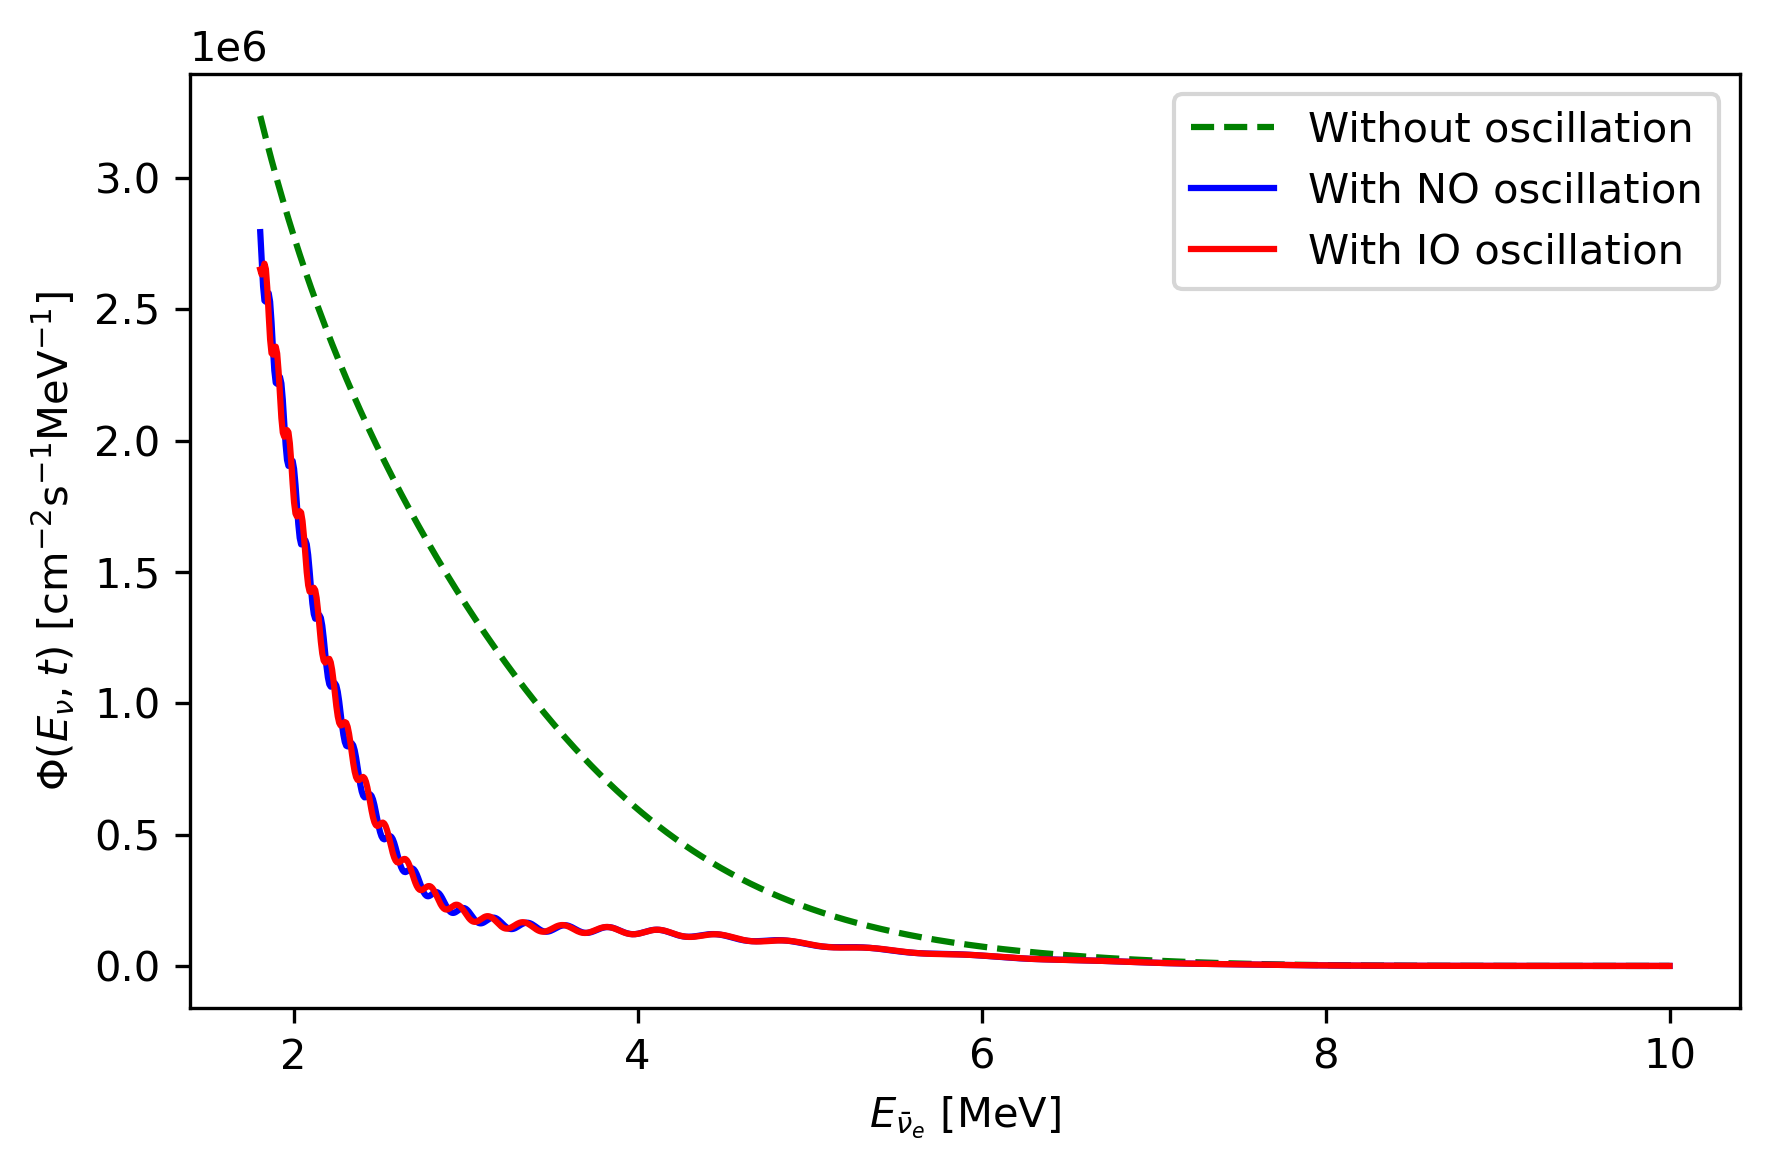

In [5]:
# Defining the antineutrino energy range [MeV]
Enu = np.linspace(1.806,10,1001)

# Initializing lists to store the flux results
flux_tot_NOosc = [] # Flux without oscillation effects
flux_tot_withosc_NO = [] # Flux with oscillation — Normal Ordering
flux_tot_withosc_IO = [] # Flux WITH oscillation — Inverted Ordering

# Looping over all antineutrino energies
for i in Enu:
    flux_tot_NOosc.append(flux(i)*Psurv_JUNO(i)[2])
    flux_tot_withosc_NO.append(flux(i)*Psurv_JUNO(i)[0])
    flux_tot_withosc_IO.append(flux(i)*Psurv_JUNO(i)[1])

# Plotting
plt.figure(dpi=300)
plt.plot(Enu, flux_tot_NOosc, '--g', label = 'Without oscillation')
plt.plot(Enu, flux_tot_withosc_NO, 'b', label = 'With NO oscillation')
plt.plot(Enu, flux_tot_withosc_IO, 'r', label = 'With IO oscillation')
plt.xlabel(r'$E_{\bar{\nu}_e} \ \text{[MeV]}$')
plt.ylabel(r'$\Phi(E_\nu, t) \ \left[\text{cm}^{-2}\text{s}^{-1}\text{MeV}^{-1}\right]$')
plt.legend()
plt.tight_layout()
plt.show()